# gNMR Analysis

In [34]:
import os
import re
import glob
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
import scipy
import scipy
from scipy.optimize import curve_fit
import matplotlib 
from pylab import *
from scipy import odr as odr
sns.set()



## ODR-Fit

In [3]:
def odrFit(xValues, xErrors, yValues, yErrors, fitFunction, startParams):
    fitModel = odr.Model(fitFunction)
    data = odr.RealData(xValues, yValues, sx=xErrors, sy=yErrors)
    fitter = odr.ODR(data, fitModel, beta0=startParams)
    out = fitter.run()
    popt = out.beta
    perr = out.sd_beta

    ndof = xValues.size - startParams.size
    for index in range(0, popt.size):
        print('p' + str(index) + ' = ' + str(round(popt[index], 3)) 
              + ' +- ' + str(round(perr[index], 3)))
    print('Chi^2 = ' + str(round(out.sum_square, 3)))
    print('red. Chi^2 = ' + str(round(out.res_var, 3)))
    print()
    return popt,perr,out

# Aufgabe 4 - Spin-Gitter Relaxationszeit

In [4]:
#import data

df_etabak_4 = pd.read_csv("../data/etabak_auf_4.csv",sep = ";",decimal=",")
df_soe_4 = pd.read_csv("../data/schweres_oel_auf_4.csv",sep=";",decimal=",")


#add errors
df_etabak_4["tau_err"] = 0.005
df_etabak_4["u_err"] = df_etabak_4["delta_v"].apply(lambda x: 0.01 if x >= 1 else 0.005)

df_soe_4["tau_err"] = 0.005
df_soe_4["u_err"] = df_soe_4["delta_v"].apply(lambda x: 0.01 if x >= 1 else 0.005)

In [5]:
df_etabak_4

,tau,delta_v,csv_datei,tau_err,u_err
0,0.005,3.5250,31,0.005,0.010
1,0.010,3.1125,32,0.005,0.010
2,0.015,2.7625,33,0.005,0.010
3,0.020,2.3750,34,0.005,0.010
4,0.025,2.0375,35,0.005,0.010
5,0.030,1.7375,36,0.005,0.010
6,0.035,1.4680,37,0.005,0.010
7,0.040,1.1812,38,0.005,0.010
8,0.045,0.9060,39,0.005,0.005
9,0.050,0.6430,40,0.005,0.005


p0 = 3.875 +- 0.023
p1 = 0.09 +- 0.002
Chi^2 = 57.204
red. Chi^2 = 2.86

Beta: [3.87469739 0.08996033]
Beta Std Error: [0.02294418 0.0023322 ]
Beta Covariance: [[1.84055536e-04 1.27123830e-05]
 [1.27123830e-05 1.90166704e-06]]
Residual Variance: 2.860198142101049
Inverse Condition #: 0.13069635045077874
Reason(s) for Halting:
  Sum of squares convergence


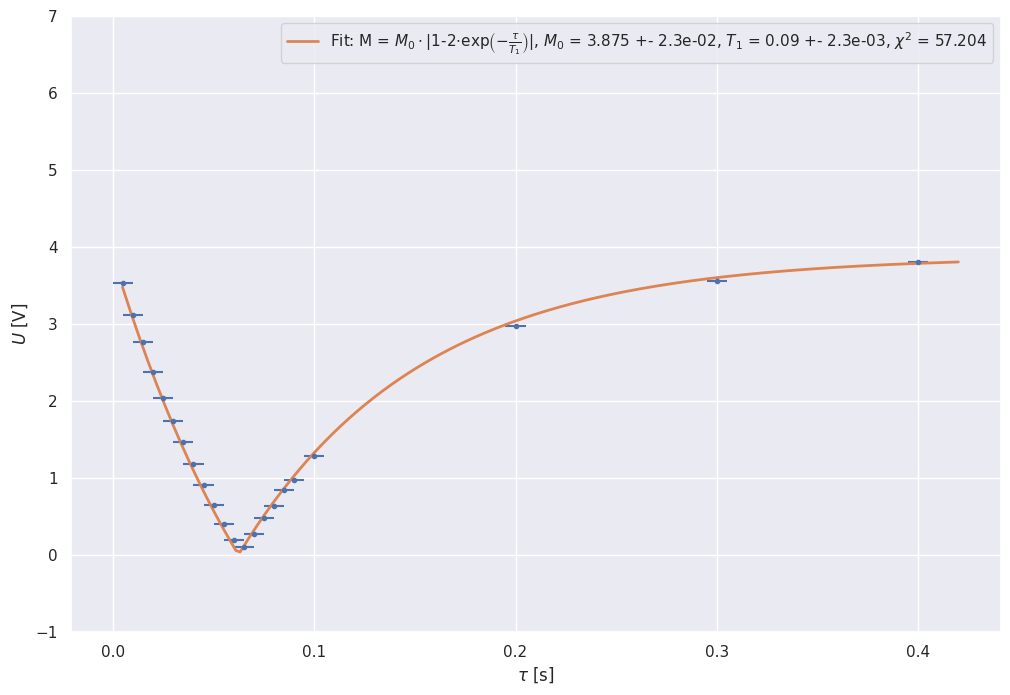

In [6]:


def fitFunc(params, x):
    m0, T1 = params
    return (m0*np.abs(1-2*(np.exp(-x/T1))))

# Define the numpy arrays with the data points and the corresponding errors:

xData = df_etabak_4["tau"].to_numpy()
xErr = df_etabak_4["tau_err"].to_numpy()
yData = df_etabak_4["delta_v"].to_numpy()
yErr = df_etabak_4["u_err"].to_numpy()

# Set the start values for the parameters of our function, and call the fit routine. 
# Remember: all arguments of our fitFunc are numpy arrays:

startParameters = np.array([yData[0], 0.065])
popt, perr, fitResult = odrFit(xData, xErr, yData, yErr, fitFunc, startParameters)
#print(popt)
#print(perr)
# Have a look to the fit result:
fitResult.pprint()

# Let's make a plot of the result:

x_fit = np.linspace(0.95*min(xData), 1.05*max(xData), 200)
fit = fitFunc(popt, x_fit)

# calculate the residuals in y direction
residuals = fitResult.eps / yErr

error_fmt = " +- {:.1e}"

fig1 = plt.figure(figsize=(12,8))
plt.errorbar(xData, yData, xerr = xErr, yerr = yErr, fmt = '.')
plt.plot(x_fit, fit, lw=2, label=
         r'Fit: M = $M_{0}\cdot$|1-2$\cdot$exp$\left(-\frac{\tau}{T_{1}}\right)$|, $M_{0}$ = ' + str(round(popt[0], 3)) + error_fmt.format(perr[0]) 
         + r', ${T_{1}}$ = ' + str(round(popt[1], 3)) + error_fmt.format(perr[1]) 
         + ', $\chi^2$ = ' + str(round(fitResult.sum_square, 3)))
plt.xlabel(r"$\tau$ [s]")
plt.ylabel(r"$U$ [V]")
plt.ylim(-1,7)
plt.legend()
#plt.title('Lebensdauer von Myonen')

# fig2 = plt.figure(figsize=(12,2.5))
# plot(xData, residuals,'or')
# plt.xlabel(r"Zeitdelay [$\mu$s]")
# plt.ylabel('Residuals')
# plt.grid()
plt.savefig("../images/aufgabe_4_etabak.jpg")
plt.show()

# The quite large values for Chi^2 and Chi^2/ndof show that this is not a good fit, what is aslo
# clearly visible in the plot. The statistical errors are not sufficient to explain the spread
# of the data points around the best curve.

p0 = 3.955 +- 0.014
p1 = 0.042 +- 0.002
Chi^2 = 47.773
red. Chi^2 = 3.981

Beta: [3.95487585 0.04218925]
Beta Std Error: [0.01404749 0.00223004]
Beta Covariance: [[4.95670954e-05 3.06944622e-06]
 [3.06944622e-06 1.24917005e-06]]
Residual Variance: 3.9811092023868864
Inverse Condition #: 0.03868482306115836
Reason(s) for Halting:
  Sum of squares convergence


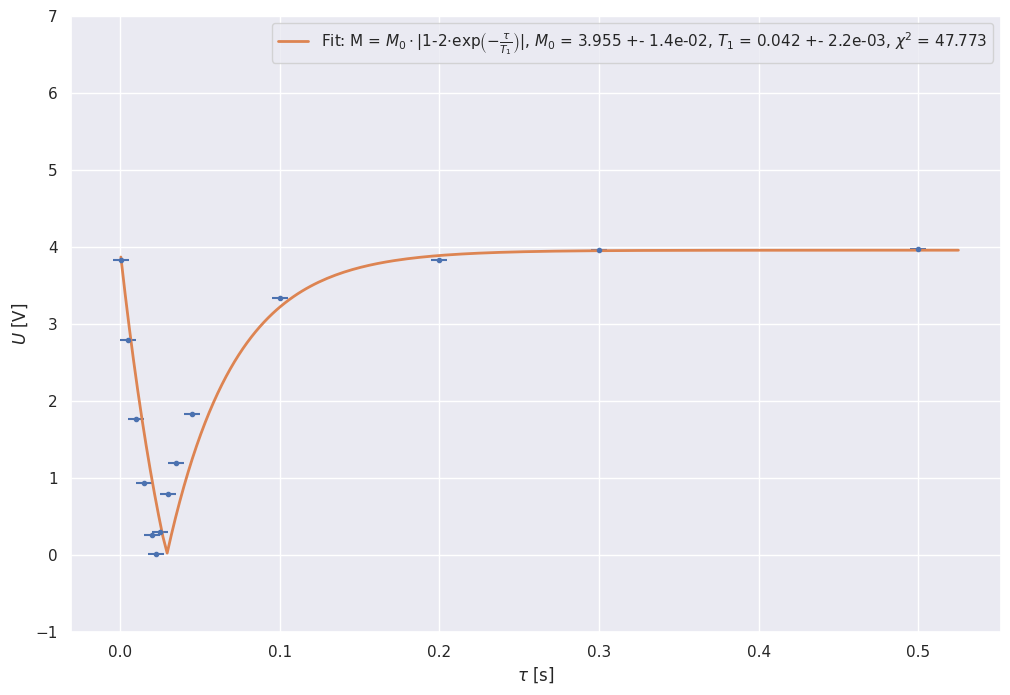

In [7]:


def fitFunc(params, x):
    m0, T1 = params
    return (m0*np.abs(1-2*(np.exp(-x/T1))))

# Define the numpy arrays with the data points and the corresponding errors:

xData = df_soe_4["tau"].to_numpy()
xErr = df_soe_4["tau_err"].to_numpy()
yData = df_soe_4["delta_v"].to_numpy()
yErr = df_soe_4["u_err"].to_numpy()

# Set the start values for the parameters of our function, and call the fit routine. 
# Remember: all arguments of our fitFunc are numpy arrays:

startParameters = np.array([yData[0], 0.025])
popt, perr, fitResult = odrFit(xData, xErr, yData, yErr, fitFunc, startParameters)
#print(popt)
#print(perr)
# Have a look to the fit result:
fitResult.pprint()

# Let's make a plot of the result:

x_fit = np.linspace(0.95*min(xData), 1.05*max(xData), 200)
fit = fitFunc(popt, x_fit)

# calculate the residuals in y direction
residuals = fitResult.eps / yErr

error_fmt = " +- {:.1e}"

fig1 = plt.figure(figsize=(12,8))
plt.errorbar(xData, yData, xerr = xErr, yerr = yErr, fmt = '.')
plt.plot(x_fit, fit, lw=2, label=
         r'Fit: M = $M_{0}\cdot$|1-2$\cdot$exp$\left(-\frac{\tau}{T_{1}}\right)$|, $M_{0}$ = ' + str(round(popt[0], 3)) + error_fmt.format(perr[0]) 
         + r', ${T_{1}}$ = ' + str(round(popt[1], 3)) + error_fmt.format(perr[1]) 
         + ', $\chi^2$ = ' + str(round(fitResult.sum_square, 3)))
plt.xlabel(r"$\tau$ [s]")
plt.ylabel(r"$U$ [V]")
plt.ylim(-1,7)
plt.legend()
#plt.title('Lebensdauer von Myonen')

# fig2 = plt.figure(figsize=(12,2.5))
# plot(xData, residuals,'or')
# plt.xlabel(r"Zeitdelay [$\mu$s]")
# plt.ylabel('Residuals')
# plt.grid()
plt.savefig("../images/aufgabe_4_soel.jpg")
plt.show()

# The quite large values for Chi^2 and Chi^2/ndof show that this is not a good fit, what is aslo
# clearly visible in the plot. The statistical errors are not sufficient to explain the spread
# of the data points around the best curve.

## Aufgabe 5 - Spin-Spin-Relaxationszeit mit Spin-Echo

In [8]:
#import data

df_etabak_5 = pd.read_csv("../data/etabak_auf_5.csv",sep = ";",decimal=",")
df_soe_5 = pd.read_csv("../data/schweres_oel_auf_5.csv",sep=";",decimal=",")


#add errors
df_etabak_5["tau_err"] = 0.0005
df_etabak_5["u_err"] = df_etabak_5["delta_v"].apply(lambda x: 0.01 if x >= 1 else 0.005)

df_soe_5["tau_err"] = 0.0005
df_soe_5["u_err"] = df_soe_5["delta_v"].apply(lambda x: 0.01 if x >= 1 else 0.005)

p0 = 4.682 +- 0.183
p1 = 0.048 +- 0.001
Chi^2 = 156.995
red. Chi^2 = 11.214

Beta: [4.68184218 0.04834722]
Beta Std Error: [0.18266472 0.00106766]
Beta Covariance: [[ 2.97543754e-03 -1.50414299e-05]
 [-1.50414299e-05  1.01650342e-07]]
Residual Variance: 11.213947242836767
Inverse Condition #: 0.14284138975493188
Reason(s) for Halting:
  Sum of squares convergence


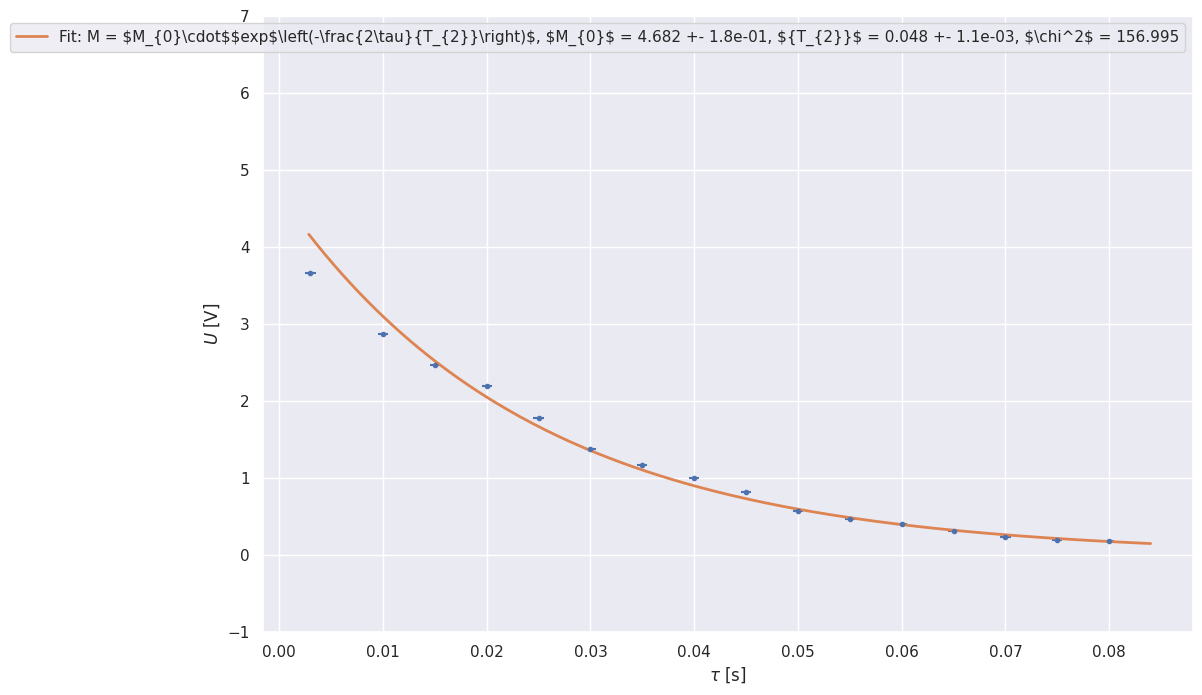

In [9]:


def fitFunc(params, x):
    m0, T2 = params
    return (m0*(np.exp(-(2*x)/T2)))

# Define the numpy arrays with the data points and the corresponding errors:

xData = df_etabak_5["tau"].to_numpy()
xErr = df_etabak_5["tau_err"].to_numpy()
yData = df_etabak_5["delta_v"].to_numpy()
yErr = df_etabak_5["u_err"].to_numpy()

# Set the start values for the parameters of our function, and call the fit routine. 
# Remember: all arguments of our fitFunc are numpy arrays:

startParameters = np.array([yData[0], 0.065])
popt, perr, fitResult = odrFit(xData, xErr, yData, yErr, fitFunc, startParameters)
#print(popt)
#print(perr)
# Have a look to the fit result:
fitResult.pprint()

# Let's make a plot of the result:

x_fit = np.linspace(0.95*min(xData), 1.05*max(xData), 200)
fit = fitFunc(popt, x_fit)

# calculate the residuals in y direction
residuals = fitResult.eps / yErr

error_fmt = " +- {:.1e}"

fig1 = plt.figure(figsize=(12,8))
plt.errorbar(xData, yData, xerr = xErr, yerr = yErr, fmt = '.')
plt.plot(x_fit, fit, lw=2, label=
         r'Fit: M = $M_{0}\cdot$$exp$\left(-\frac{2\tau}{T_{2}}\right)$, $M_{0}$ = ' + str(round(popt[0], 3)) + error_fmt.format(perr[0]) 
         + r', ${T_{2}}$ = ' + str(round(popt[1], 3)) + error_fmt.format(perr[1]) 
         + ', $\chi^2$ = ' + str(round(fitResult.sum_square, 3)))
plt.xlabel(r"$\tau$ [s]")
plt.ylabel(r"$U$ [V]")
plt.ylim(-1,7)
plt.legend()
#plt.title('Lebensdauer von Myonen')

# fig2 = plt.figure(figsize=(12,2.5))
# plot(xData, residuals,'or')
# plt.xlabel(r"Zeitdelay [$\mu$s]")
# plt.ylabel('Residuals')
# plt.grid()
plt.savefig("../images/aufgabe_5_etabak.jpg")
plt.show()

# The quite large values for Chi^2 and Chi^2/ndof show that this is not a good fit, what is aslo
# clearly visible in the plot. The statistical errors are not sufficient to explain the spread
# of the data points around the best curve.

p0 = 2.909 +- 0.389
p1 = 0.022 +- 0.001
Chi^2 = 178.51
red. Chi^2 = 22.314

Beta: [2.90915531 0.02210361]
Beta Std Error: [0.3892594  0.00145528]
Beta Covariance: [[ 6.79057081e-03 -2.06967919e-05]
 [-2.06967919e-05  9.49115817e-08]]
Residual Variance: 22.31371817977187
Inverse Condition #: 0.24855423317265354
Reason(s) for Halting:
  Sum of squares convergence


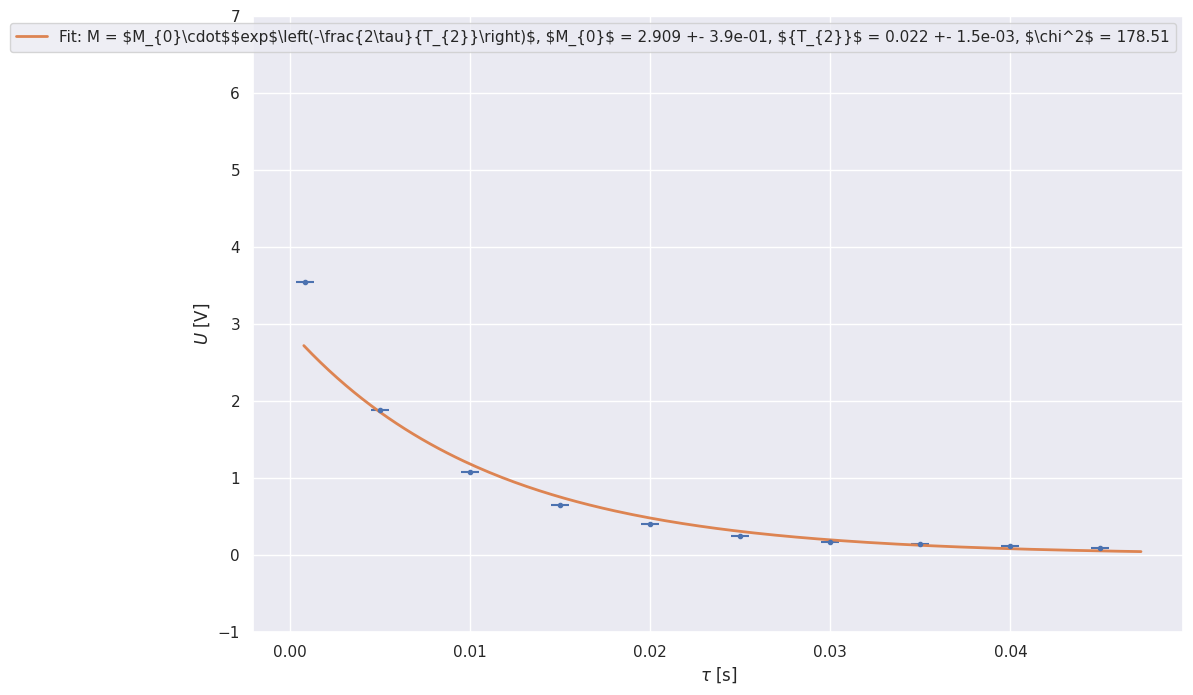

In [10]:


def fitFunc(params, x):
    m0, T2 = params
    return (m0*(np.exp(-(2*x)/T2)))

# Define the numpy arrays with the data points and the corresponding errors:

xData = df_soe_5["tau"].to_numpy()
xErr = df_soe_5["tau_err"].to_numpy()
yData = df_soe_5["delta_v"].to_numpy()
yErr = df_soe_5["u_err"].to_numpy()

# Set the start values for the parameters of our function, and call the fit routine. 
# Remember: all arguments of our fitFunc are numpy arrays:

startParameters = np.array([yData[0], 0.025])
popt, perr, fitResult = odrFit(xData, xErr, yData, yErr, fitFunc, startParameters)
#print(popt)
#print(perr)
# Have a look to the fit result:
fitResult.pprint()

# Let's make a plot of the result:

x_fit = np.linspace(0.95*min(xData), 1.05*max(xData), 200)
fit = fitFunc(popt, x_fit)

# calculate the residuals in y direction
residuals = fitResult.eps / yErr

error_fmt = " +- {:.1e}"

fig1 = plt.figure(figsize=(12,8))
plt.errorbar(xData, yData, xerr = xErr, yerr = yErr, fmt = '.')
plt.plot(x_fit, fit, lw=2, label=
         r'Fit: M = $M_{0}\cdot$$exp$\left(-\frac{2\tau}{T_{2}}\right)$, $M_{0}$ = ' + str(round(popt[0], 3)) + error_fmt.format(perr[0]) 
         + r', ${T_{2}}$ = ' + str(round(popt[1], 3)) + error_fmt.format(perr[1]) 
         + ', $\chi^2$ = ' + str(round(fitResult.sum_square, 3)))
plt.xlabel(r"$\tau$ [s]")
plt.ylabel(r"$U$ [V]")
plt.ylim(-1,7)
plt.legend()
#plt.title('Lebensdauer von Myonen')

# fig2 = plt.figure(figsize=(12,2.5))
# plot(xData, residuals,'or')
# plt.xlabel(r"Zeitdelay [$\mu$s]")
# plt.ylabel('Residuals')
# plt.grid()
plt.savefig("../images/aufgabe_5_soel.jpg")
plt.show()

# The quite large values for Chi^2 and Chi^2/ndof show that this is not a good fit, what is aslo
# clearly visible in the plot. The statistical errors are not sufficient to explain the spread
# of the data points around the best curve.

## Aufgabe 6 Car-Purcell vs Meiboom-Gill

In [11]:
#import data
df_soel_CP = pd.read_csv("../data/scope_files/scope_29.csv",sep=",",header=[0,1])
df_soel_MG = pd.read_csv("../data/scope_files/scope_30.csv",sep=",",header=[0,1])
df_soel_CP.columns = df_soel_CP.columns.map('_'.join)
df_soel_MG.columns = df_soel_MG.columns.map('_'.join)
df_soel_MG["tau_err"] = 0.0005
df_soel_MG["u1_err"] = df_soel_MG["1_Volt"].apply(lambda x: 0.01 if x >= 1 else 0.005)
df_soel_MG["u2_err"] = df_soel_MG["2_Volt"].apply(lambda x: 0.01 if x >= 1 else 0.005)

df_soel_CP["tau_err"] = 0.0005
df_soel_CP["u1_err"] = df_soel_CP["1_Volt"].apply(lambda x: 0.01 if x >= 1 else 0.005)
df_soel_CP["u2_err"] = df_soel_CP["2_Volt"].apply(lambda x: 0.01 if x >= 1 else 0.005)

df_soel_CP = df_soel_CP.loc[df_soel_CP["x-axis_second"]>=0]
df_soel_MG = df_soel_MG.loc[df_soel_MG["x-axis_second"]>=0]


df_etabak_CP = pd.read_csv("../data/scope_files/scope_71.csv",sep=",",header=[0,1])
df_etabak_MG = pd.read_csv("../data/scope_files/scope_72.csv",sep=",",header=[0,1])
df_etabak_CP.columns = df_etabak_CP.columns.map('_'.join)
df_etabak_MG.columns = df_etabak_MG.columns.map('_'.join)

In [12]:
df_soel_CP

,x-axis_second,1_Volt,2_Volt,tau_err,u1_err,u2_err
1000,0.000,-0.247475,2.596264,0.0005,0.005,0.010
1001,0.001,-0.197224,2.596264,0.0005,0.005,0.010
1002,0.002,0.106043,1.871389,0.0005,0.005,0.010
1003,0.003,0.045490,1.258324,0.0005,0.005,0.010
1004,0.004,0.113832,0.827420,0.0005,0.005,0.005
...,...,...,...,...,...,...
1995,0.995,-0.004510,0.063601,0.0005,0.005,0.005
1996,0.996,-0.010289,0.082445,0.0005,0.005,0.005
1997,0.997,-0.000490,0.062344,0.0005,0.005,0.005
1998,0.998,-0.010289,0.063601,0.0005,0.005,0.005


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='x-axis_second', ylabel='1_Volt'>

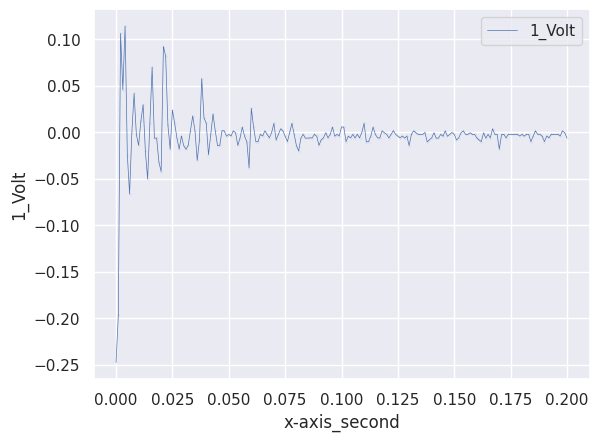

In [13]:
ax1 = df_soel_CP.loc[df_soel_CP["x-axis_second"] <= 0.2].plot.scatter(x="x-axis_second",y="1_Volt",s=0.005)
df_soel_CP.loc[df_soel_CP["x-axis_second"] <= 0.2].plot.line(x=0, y=1, ax=ax1, style='b', lw = 0.5)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='x-axis_second', ylabel='1_Volt'>

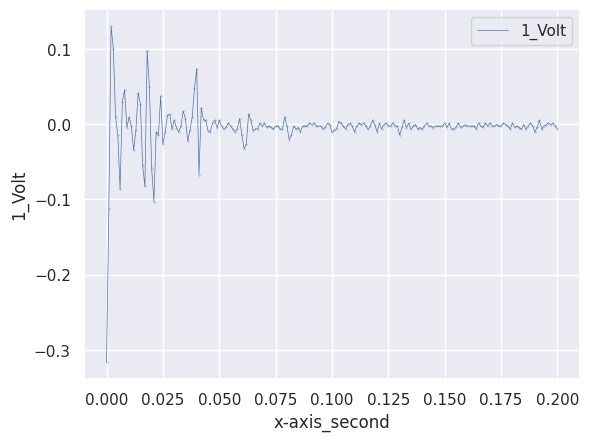

In [14]:
ax4 = df_soel_MG.loc[df_soel_MG["x-axis_second"] <= 0.2].plot.scatter(x="x-axis_second",y="1_Volt",s=0.05)
df_soel_MG.loc[df_soel_MG["x-axis_second"] <= 0.2].plot.line(x=0, y=1, ax=ax4, style='b', lw = 0.5)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='x-axis_second', ylabel='2_Volt'>

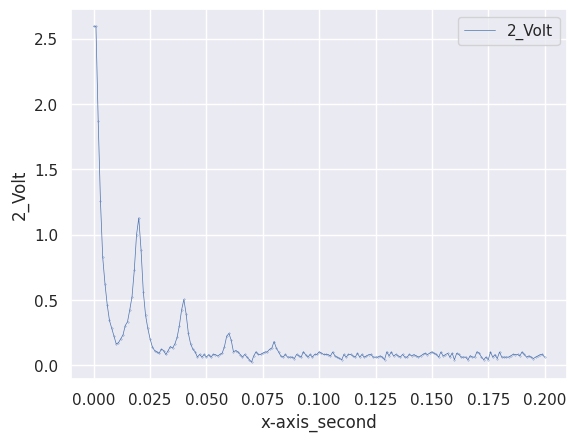

In [15]:
ax2 = df_soel_CP.loc[df_soel_CP["x-axis_second"] <= 0.2].plot.scatter(x="x-axis_second",y="2_Volt",s=0.05)
df_soel_CP.loc[df_soel_CP["x-axis_second"] <= 0.2].plot.line(x=0, y=2, ax=ax2, style='b', lw = 0.5)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='x-axis_second', ylabel='2_Volt'>

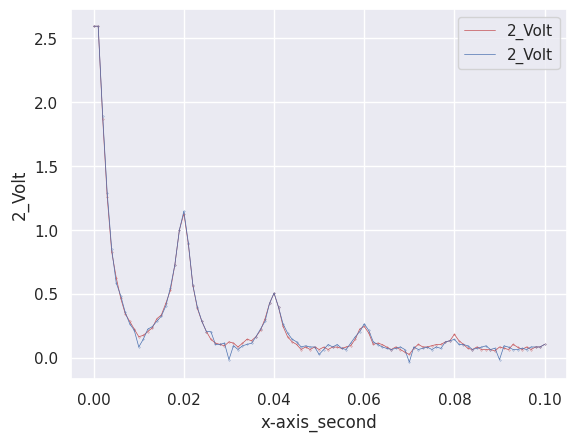

In [29]:
#ax3 = df_soel_MG.loc[df_soel_MG["x-axis_second"] <= 0.2].plot.scatter(x="x-axis_second",y="2_Volt",s=0.05)
ax2 = df_soel_CP.loc[df_soel_CP["x-axis_second"] <= 0.1].plot.scatter(x="x-axis_second",y="2_Volt",s=0.05,color="r")
df_soel_CP.loc[df_soel_CP["x-axis_second"] <= 0.1].plot.line(x=0, y=2, ax=ax2, style='r', lw = 0.5)
df_soel_MG.loc[df_soel_MG["x-axis_second"] <= 0.1].plot.scatter(x="x-axis_second",y="2_Volt",ax = ax2,s=0.05)
df_soel_MG.loc[df_soel_MG["x-axis_second"] <= 0.1].plot.line(x=0, y=2, ax=ax2, style='b', lw = 0.5)

p0 = 14.769 +- 17.642
p1 = 0.004 +- 0.001
p2 = 0.094 +- 0.009
Chi^2 = 22630.532
red. Chi^2 = 230.924

Beta: [1.47692084e+01 4.37063646e-03 9.41589292e-02]
Beta Std Error: [1.76420893e+01 1.34849537e-03 9.45680056e-03]
Beta Covariance: [[ 1.34781828e+00 -9.92563376e-05  1.40444195e-04]
 [-9.92563376e-05  7.87463129e-09 -1.36003465e-08]
 [ 1.40444195e-04 -1.36003465e-08  3.87275273e-07]]
Residual Variance: 230.92379798122715
Inverse Condition #: 0.0008074537844729706
Reason(s) for Halting:
  Sum of squares convergence


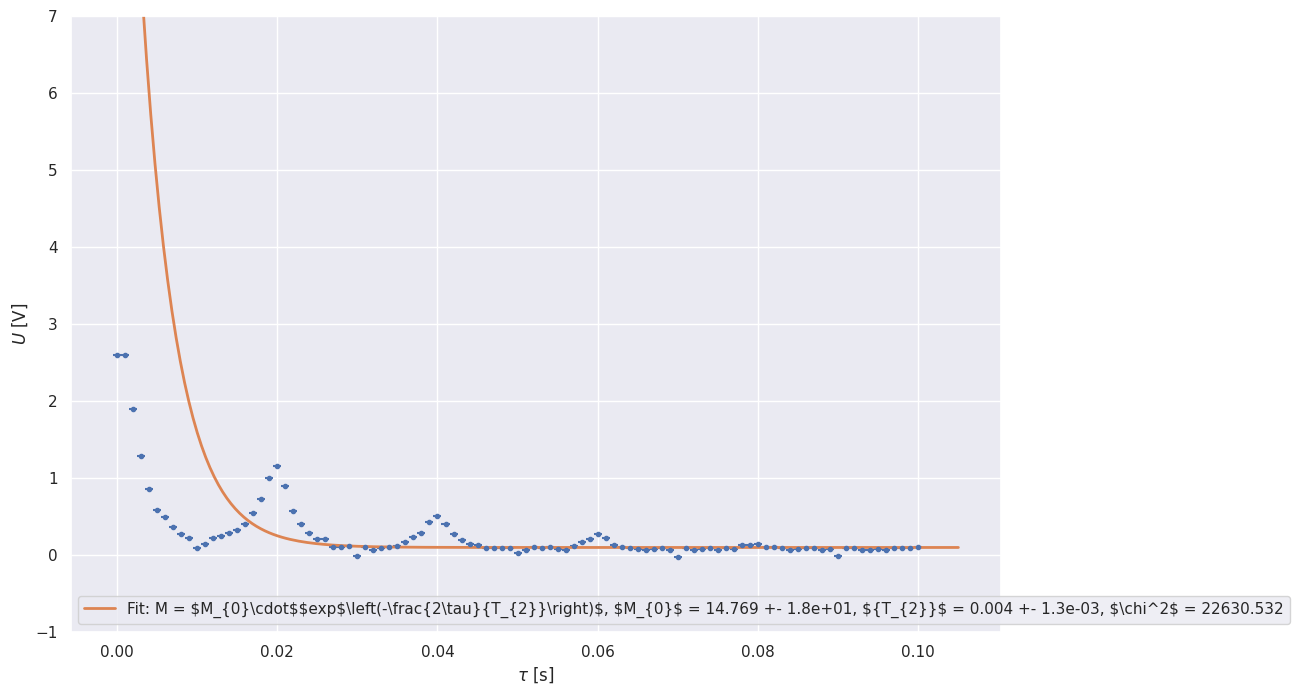

In [30]:


def fitFunc(params, x):
    m0, T2, c = params
    return (m0*(np.exp(-(x)/T2))+c)

# Define the numpy arrays with the data points and the corresponding errors:
df_soel_plot = df_soel_MG.loc[df_soel_MG["x-axis_second"] <= 0.1]
xData = df_soel_plot["x-axis_second"].to_numpy()
xErr = df_soel_plot["tau_err"].to_numpy()
yData = df_soel_plot["2_Volt"].to_numpy()
yErr = df_soel_plot["u2_err"].to_numpy()

# Set the start values for the parameters of our function, and call the fit routine. 
# Remember: all arguments of our fitFunc are numpy arrays:

startParameters = np.array([yData[0], 0.065,0.07])
popt, perr, fitResult = odrFit(xData, xErr, yData, yErr, fitFunc, startParameters)
#print(popt)
#print(perr)
# Have a look to the fit result:
fitResult.pprint()

# Let's make a plot of the result:

x_fit = np.linspace(0.95*min(xData), 1.05*max(xData), 200)
fit = fitFunc(popt, x_fit)

# calculate the residuals in y direction
residuals = fitResult.eps / yErr

error_fmt = " +- {:.1e}"

fig1 = plt.figure(figsize=(12,8))
plt.errorbar(xData, yData, xerr = xErr, yerr = yErr, fmt = '.')
plt.plot(x_fit, fit, lw=2, label=
         r'Fit: M = $M_{0}\cdot$$exp$\left(-\frac{2\tau}{T_{2}}\right)$, $M_{0}$ = ' + str(round(popt[0], 3)) + error_fmt.format(perr[0]) 
         + r', ${T_{2}}$ = ' + str(round(popt[1], 3)) + error_fmt.format(perr[1]) 
         + ', $\chi^2$ = ' + str(round(fitResult.sum_square, 3)))
plt.xlabel(r"$\tau$ [s]")
plt.ylabel(r"$U$ [V]")
plt.ylim(-1,7)
plt.legend()
#plt.title('Lebensdauer von Myonen')

# fig2 = plt.figure(figsize=(12,2.5))
# plot(xData, residuals,'or')
# plt.xlabel(r"Zeitdelay [$\mu$s]")
# plt.ylabel('Residuals')
# plt.grid()
plt.savefig("../images/aufgabe_6_soel_mg.jpg")
plt.show()

# The quite large values for Chi^2 and Chi^2/ndof show that this is not a good fit, what is aslo
# clearly visible in the plot. The statistical errors are not sufficient to explain the spread
# of the data points around the best curve.

## Chemische Verschiebung

In [72]:
#import data
import copy
dict_fluor = {"FC_43":76,"FC_70":77,"FC_770":78,"HT_770":79}
dict_fluor_dfs = {}

for k,v in dict_fluor.items():
    df = pd.read_csv(f"../data/scope_files/scope_{v}.csv",sep=",")
    df.dropna(inplace=True,axis=0)
    #df = df.stack().str.replace(',','.').unstack()
    #df["Volt_2"] = df["Volt_2"].apply(lambda x: x.str.replace(',','.'))
    df["Volt_2"]=df["Volt_2"].astype(float)
    dict_fluor_dfs[k]= copy.deepcopy(df)



In [73]:
dict_fluor_dfs["FC_43"]

,<,Volt_1,Hertz,Volt_2
2,-0.004990,0.003040,1510.0,0.001822
3,-0.004985,0.003040,1515.0,0.001822
4,-0.004980,0.002538,1520.0,0.001822
5,-0.004975,0.003040,1525.0,0.001822
6,-0.004970,0.003040,1530.0,0.001831
...,...,...,...,...
1995,0.004975,0.003040,11475.0,0.767016
1996,0.004980,0.003040,11480.0,0.767016
1997,0.004985,0.003040,11485.0,0.776782
1998,0.004990,0.003040,11490.0,0.776782


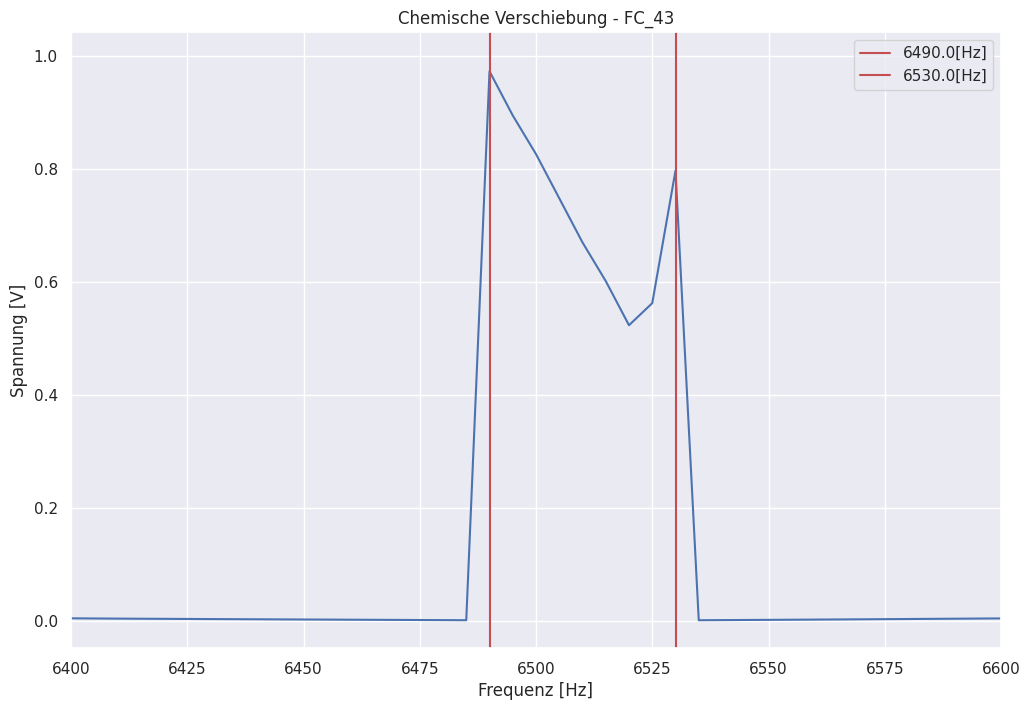

{'prominences': array([0.97105355, 0.273437  ]), 'left_bases': array([ 995, 1002]), 'right_bases': array([1005, 1005])}


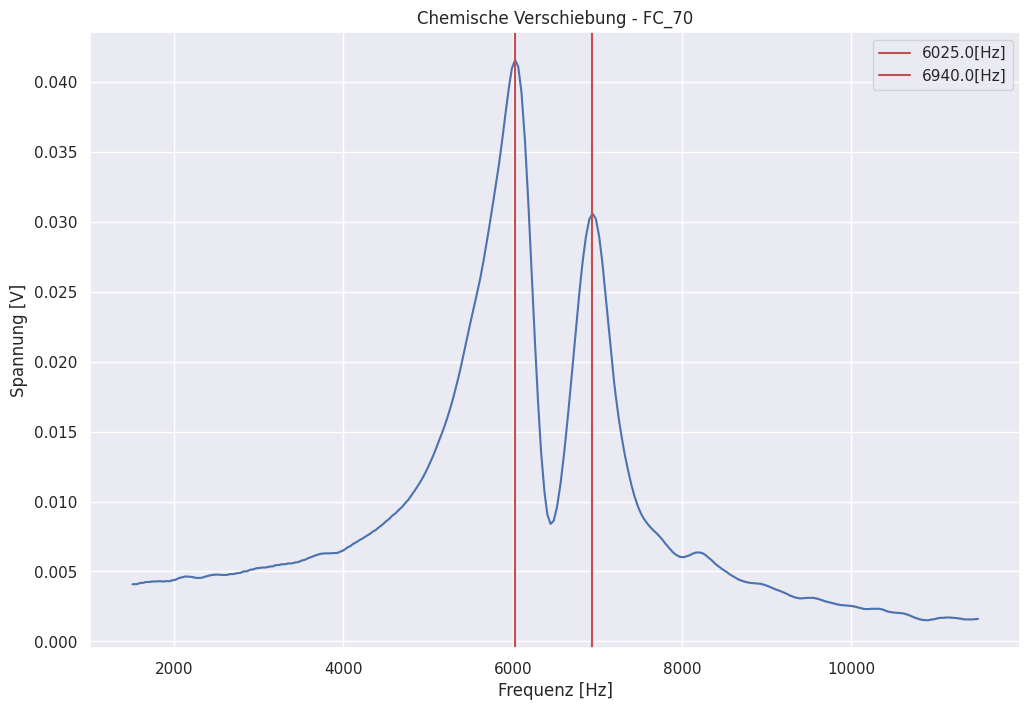

{'prominences': array([0.03746094, 0.02216797]), 'left_bases': array([ 10, 988]), 'right_bases': array([1697, 1697])}


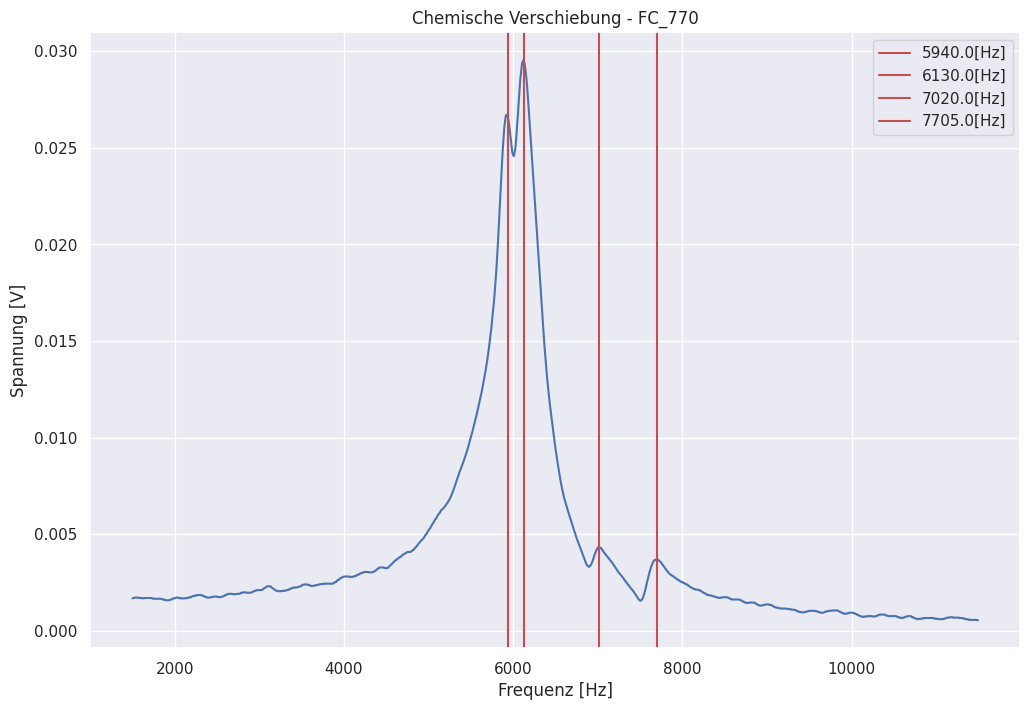

{'prominences': array([0.00214843, 0.02796875, 0.0009961 , 0.00212891]), 'left_bases': array([  87,   87, 1080, 1202]), 'right_bases': array([ 901, 1684, 1684, 1684])}


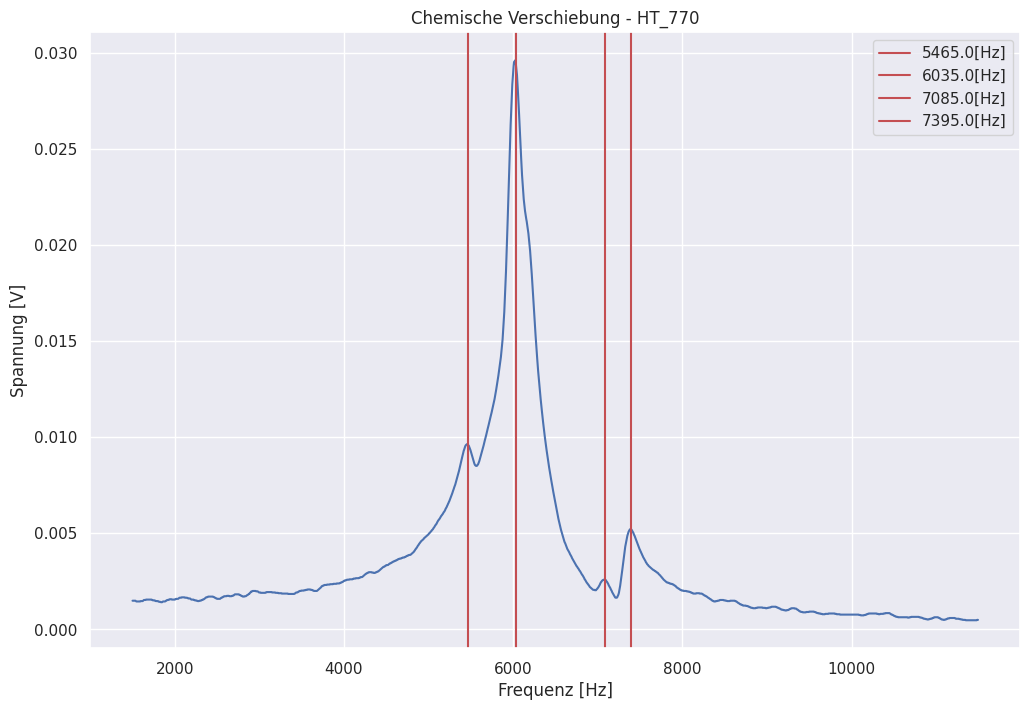

{'prominences': array([0.00113281, 0.0281836 , 0.00054688, 0.00355469]), 'left_bases': array([  70,   70, 1096, 1145]), 'right_bases': array([ 812, 1673, 1142, 1673])}


In [137]:
dict_xvals={
    "FC_43":0.03,
    "FC_70":0.003,
    "FC_770":0.0003,
    "HT_770":0.0003
}
for art in dict_fluor.keys():
    fig1 = plt.figure(figsize=(12,8))

    if art == "FC_43":
        xmax = 7000
        xmin=6000
    else:
        xmax=10000
        xmin=2000
    plt.plot(dict_fluor_dfs[art]["Hertz"], dict_fluor_dfs[art]["Volt_2"])
    #peaks, _ = scipy.signal.find_peaks(x=dict_fluor_dfs[art]["Volt_2"].loc[dict_fluor_dfs[art]["Hertz"]<=xmax],height=[0.6,1])
    peaks, _dict = scipy.signal.find_peaks(x=dict_fluor_dfs[art]["Volt_2"].loc[dict_fluor_dfs[art]["Hertz"]<=xmax],prominence = dict_xvals[art])
    
    #plt.plot(dict_fluor_dfs["FC_43"]["Hertz"][peaks+2], dict_fluor_dfs["FC_43"]["Volt_2"][peaks+2], "x")
    #plt.vlines(dict_fluor_dfs["FC_43"]["Hertz"][peaks+2], ymin=0,ymax=dict_fluor_dfs["FC_43"]["Volt_2"].max(),color="r")
    for xc in peaks:
        plt.axvline(x=dict_fluor_dfs[art]["Hertz"][xc+2],label=f'{dict_fluor_dfs[art]["Hertz"][xc+2]}[Hz]',color="r")

    plt.xlabel("Frequenz [Hz]")
    plt.ylabel("Spannung [V]")
    if art == "FC_43":
        plt.xlim(6400,6600)
    plt.legend()
    plt.title(f'Chemische Verschiebung - {art}')

    # fig2 = plt.figure(figsize=(12,2.5))
    # plot(xData, residuals,'or')
    # plt.xlabel(r"Zeitdelay [$\mu$s]")
    # plt.ylabel('Residuals')
    # plt.grid()
    plt.savefig(f"../images/aufgabe_7_{art}.jpg")
    plt.show()
    print(_dict)

In [93]:
scipy.signal.find_peaks(x=dict_fluor_dfs["FC_43"]["Volt_2"].loc[dict_fluor_dfs["FC_43"]["Hertz"]<=7000],height=0.6)

(array([ 996, 1004]), {'peak_heights': array([0.972094, 0.796313])})

In [104]:
dict_fluor_dfs["FC_43"].iloc[997]

<           -5.000000
Volt_1      -0.005000
Hertz     6495.000000
Volt_2       0.893969
Name: 999, dtype: float64